# Convolutional Neural Network 

### Data Preprocessing

In [1]:
import warnings
import json
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
#%matplotlib inline

In [2]:
categories = ['business','entertainment','general','health',
            'technology', 'sports']
cat_num_map ={
    'business': 0,
    'entertainment':1,
    'general': 2,
    'health' : 3,
    'technology': 4,
    'sports' : 5
}
news_store = list()
with open('./news_baseline.json','r',encoding="utf8") as f :
    ls = f.readlines()
    for l in ls:
        news = json.loads(l)
        #combine sci with tech 
        if(news['category']=="science"):
            news['category']="technology"
        # combine title and description
        # to-dos
        news_store.append(news)
    
news_store = pd.DataFrame(news_store)
news_store.drop('_id', axis=1, inplace=True)

In [3]:
# prepare training and testing data
data = news_store.sample(frac=1.0)
test_num = int(0.2 * data.shape[0]) # 20% percent of test data
data_test = data[:test_num]
data_train = data[test_num:]
X_test_raw = data_test['description']
Y_test_str = data_test['category']
X_train_raw = data_train['description']
Y_train_str = data_train['category']
Y_test = list()
Y_train = list()
# convert str to numbers
for d in Y_test_str:
    Y_test.append(cat_num_map[d])

for d in Y_train_str:
    Y_train.append(cat_num_map[d])
    
print('Test data num: {}\nTraining data num: {}'.format(test_num,data.shape[0]-test_num))

Test data num: 1251
Training data num: 5008


In [290]:
#Tokenize words: get rid of stop words and punctuation + word stemming.
# stop = stopwords.words('english') + list(string.punctuation)
# tok_corpus = list()
# for sent in news_store['description']:
#     tokenized_sent = [d for d in nltk.RegexpTokenizer(r'\w+').tokenize(sent.lower()) if d not in stop]
#     for i, w in enumerate(tokenized_sent):
#         tokenized_sent[i] = SnowballStemmer('english').stem(w)
#     tok_corpus.append(tokenized_sent) 


In [5]:
X_train_tok = list()
X_test_tok  = list()

stop = stopwords.words('english') + list(string.punctuation)
for sent in X_train_raw:
    tokenized_sent = [d for d in nltk.RegexpTokenizer(r'\w+').tokenize(sent.lower()) if d not in stop]
#     for i, w in enumerate(tokenized_sent):
#         tokenized_sent[i] = SnowballStemmer('english').stem(w)
    X_train_tok.append(tokenized_sent) 

for sent in X_test_raw:
    tokenized_sent = [d for d in nltk.RegexpTokenizer(r'\w+').tokenize(sent.lower()) if d not in stop]
#     for i, w in enumerate(tokenized_sent):
#         tokenized_sent[i] = SnowballStemmer('english').stem(w)
    X_test_tok.append(tokenized_sent) 

### Word2Vector Model

In [8]:
# w2v_model = gensim.models.Word2Vec(tok_corpus, size=100, window=5, min_count=1, workers=4)
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [97]:
t = X_train_tok+X_test_tok
voc = list()
max_sent_len = 0
for sent in t:
    if(len(sent)>max_sent_len):
        max_sent_len = len(sent)
    for w in sent:
        voc.append(w)

print('There are {} words in total;\nMax sentence length is {}'.format(len(np.unique(voc)),max_sent_len))

There are 15754 words in total;
Max sentence length is 39


In [98]:
# convert input to vector
X_train = list()
X_test  = list()

for doc in X_train_tok:
    doc_vec = list()
    for i in range(40):
        try:
            w = doc[i] # i-th word(w)
            w_vec = w2v_model[w]
            doc_vec.append(w_vec)
        except Exception:
            doc_vec.append(np.zeros(300))
    X_train.append(doc_vec)
    
for doc in X_test_tok:
    doc_vec = list()
    for i in range(40):
        try:
            w = doc[i] # i-th word(w)
            w_vec = w2v_model[w]
            doc_vec.append(w_vec)
        except Exception:
            doc_vec.append(np.zeros(300))
    X_test.append(doc_vec)

In [99]:
# convert to numpy array
X_train = np.asarray(X_train, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)
Y_test  = np.asarray(Y_test, dtype=np.float32)

### Build CNN

In [110]:
'''Start CNN'''
def cnn_model_fn(features, labels, mode):

    input_layer = tf.reshape(features["x"], [-1,40,300,1])
    
    conv1 = tf.layers.conv2d(
            inputs=input_layer,
            filters=30,
            kernel_size=[3,3],
            padding='SAME',
            activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(
            inputs=conv1,
            pool_size=[10,10],
            strides=10,
            padding='SAME')
    
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=10,
            kernel_size=[3,3],
            padding='SAME',
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(
            inputs=conv2,
            pool_size=[2,2],
            strides=2)
    
    # fully-connected layers with dropout
    pool2_flat = tf.reshape(pool2,[-1,10*2*15])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate = 0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=6)
    
    
    
    predictions={
        "classes": tf.argmax(input=logits,axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor") 
    }
    #PREDICT
    if (mode == tf.estimator.ModeKeys.PREDICT):
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=6)
    print(onehot_labels.shape)
    loss = tf.losses.softmax_cross_entropy(
                                onehot_labels=onehot_labels, logits=logits)
    #loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logtis)
    #TRAIN
    if mode == tf.estimator.ModeKeys.TRAIN:
        #-=================Various Optimizers=============================
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        #optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
        #optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.001)
        #-================================================================
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    #Else mode == EVAL 
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
        labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
    

In [387]:
# for test only
# mnist = tf.contrib.learn.datasets.load_dataset("mnist")
# train_data = mnist.train.images # Returns np.array
# train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
# eval_data = mnist.test.images # Returns np.array
# eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [115]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=100)


clf = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./news_Adam_bigpoll")


train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=50,
    num_epochs=None,
    shuffle=True)

clf.train(
    input_fn=train_input_fn,
    steps=500,
    hooks=[logging_hook])

    
# if __name__ == "__main__":
#     tf.app.run()


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_save_checkpoints_steps': None, '_task_type': 'worker', '_session_config': None, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000024635E6F780>, '_is_chief': True, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_num_worker_replicas': 1, '_tf_random_seed': None, '_num_ps_replicas': 0, '_task_id': 0, '_save_checkpoints_secs': 600, '_model_dir': './news_Adam_bigpoll', '_keep_checkpoint_max': 5}
(50, 6)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./news_Adam_bigpoll\model.ckpt-500
INFO:tensorflow:Saving checkpoints for 501 into ./news_Adam_bigpoll\model.ckpt.
INFO:tensorflow:probabilities = [[ 0.0982549   0.2575106   0.11098693  0.00365219  0.37336892  0.15622637]
 [ 0.14328344  0.12056858  0.38707814  0.01957032  0.23036496  0.09913453]
 [ 0.1029921   0.230929

INFO:tensorflow:loss = 1.24305, step = 601 (84.737 sec)
INFO:tensorflow:global_step/sec: 1.4766
INFO:tensorflow:probabilities = [[ 0.13872008  0.04281943  0.10765843  0.01371101  0.53452075  0.16257025]
 [ 0.52202463  0.01223807  0.0938559   0.20082693  0.16084057  0.01021389]
 [ 0.03522057  0.13435237  0.0498876   0.05694563  0.56754255  0.15605122]
 [ 0.00543086  0.12037306  0.13056456  0.0021779   0.01648156  0.72497213]
 [ 0.00843193  0.66076809  0.09577893  0.01400383  0.08664536  0.13437194]
 [ 0.01519132  0.2589983   0.19721778  0.02497768  0.07360853  0.43000641]
 [ 0.32625702  0.04663008  0.36369646  0.05887851  0.1801151   0.0244229 ]
 [ 0.30910128  0.01531329  0.48940995  0.13811569  0.01159189  0.03646786]
 [ 0.01341225  0.31326845  0.0632219   0.00198521  0.01967395  0.58843821]
 [ 0.07119092  0.03751874  0.32325664  0.01293886  0.05060653  0.50448829]
 [ 0.02517214  0.22628251  0.12102523  0.01950318  0.07444388  0.53357303]
 [ 0.01388288  0.16172501  0.13596928  0.004674

INFO:tensorflow:loss = 1.16617, step = 901 (71.797 sec)
INFO:tensorflow:Saving checkpoints for 1000 into ./news_Adam_bigpoll\model.ckpt.
INFO:tensorflow:Loss for final step: 1.23639.


### Performance Evaluation

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": X_test},
  y=Y_test,
  num_epochs=1,
  shuffle=False)
eval_results = clf.evaluate(input_fn=eval_input_fn)
print(eval_results)

In [ ]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": X_test},
  y=Y_test,
  num_epochs=1,
  shuffle=False)

clf.predict(input_fn=pred_input_fn)

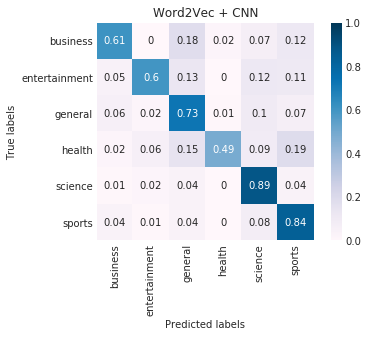

In [139]:
#============================ Confusion Matrix==============================================
import seaborn as sns
from sklearn.metrics import confusion_matrix

con_mat = confusion_matrix(Y_test_str,Y_pred_lin).astype(np.float)
for i,row in enumerate(con_mat):
    row = row / float(sum(row))
    con_mat[i] = row.round(2)

with sns.axes_style("white"):
    ax = sns.heatmap(con_mat, vmax=1, vmin=0 ,square=True, xticklabels=categories,
                     yticklabels=categories,cmap="PuBu",annot =True)

plt.title("Word2Vec + CNN")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()